# setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%%capture
!pip install git+https://github.com/EleutherAI/sae.git

In [ ]:
# you should load this before cloning repo files
# from .config import SaeConfig
# from .utils import decoder_impl

from sae.config import SaeConfig
from sae.utils import decoder_impl
from sae import Sae

Triton not installed, using eager implementation of SAE decoder.


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
from fnmatch import fnmatch
from pathlib import Path
from typing import NamedTuple, Optional, Callable, Union, List, Tuple
# from jaxtyping import Float, Int

import einops
import torch
from torch import Tensor, nn
from huggingface_hub import snapshot_download
from natsort import natsorted
from safetensors.torch import load_model, save_model

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from collections import Counter

## corr fns

In [ ]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        end = min(start + batch_size, normalized_B.shape[1])
        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        # max_indices.append(max_idx + start)  # Adjust indices for the batch offset
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    return torch.cat(max_indices), torch.cat(max_values)

## sim fns

In [ ]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [ ]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [ ]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [ ]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [ ]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [ ]:
def score_rand(num_feats, sim_fn, shapereq_bool, weight_matrix_np, weight_matrix_2):
    all_rand_scores = []
    for i in range(1):
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

        if shapereq_bool:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
        else:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
        all_rand_scores.append(score)
    # print(sum(all_rand_scores) / len(all_rand_scores))
    # plt.hist(all_rand_scores)
    # plt.show()
    return sum(all_rand_scores) / len(all_rand_scores)

In [ ]:
# import random
# row_idxs = list(range(weight_matrix_2.shape[0]))
# random.shuffle(row_idxs)
# jaccard_similarity(weight_matrix_np, weight_matrix_2[row_idxs])

## plot fns

In [ ]:
def plot_svcca_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['svcca_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_meanCorr_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr'] for i in range(0, 12)]
    # unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    # rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    # label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_meanCorr_filt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [ ]:
# def plot_js_byLayer(layer_to_dictscores):
#     for key, sub_dict in layer_to_dictscores.items():
#         for sub_key, value in sub_dict.items():
#             sub_dict[sub_key] = round(value, 4)

#     layers = [f'L{i}' for i in range(0, 12)]
#     paired_values = [layer_to_dictscores[i]['1-1 jaccard_paired'] for i in range(0, 12)]
#     unpaired_values = [layer_to_dictscores[i]['1-1 jaccard_unpaired'] for i in range(0, 12)]

#     # Plotting configuration
#     x = np.arange(len(layers))  # label locations
#     width = 0.35  # width of the bars

#     # Increase figure size
#     fig, ax = plt.subplots(figsize=(12, 7))  # Slightly increased figure size
#     rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
#     rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

#     # Adding labels, title and custom x-axis tick labels
#     ax.set_ylabel('Jaccard NN')
#     ax.set_title('SAEs comparison by Pythia 70m MLP0 vs 160m MLP Layers')
#     ax.set_xticks(x)
#     ax.set_xticklabels(layers)
#     ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
#     ax.legend()

#     # Label bars with increased font size and different positioning for paired and unpaired
#     def label_bars(rects, is_paired):
#         for rect in rects:
#             height = rect.get_height()
#             label_height = height + 0.05 if is_paired else height + 0.01
#             ax.text(rect.get_x() + rect.get_width()/2., label_height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)  # Increased font size to 12

#     label_bars(rects1, True)   # Paired bars
#     label_bars(rects2, False)  # Unpaired bars

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     # Increase y-axis limit to accommodate higher labels
#     ax.set_ylim(0, 1.1)  # Increased from 1 to 1.1

#     plt.show()

## interpret fns

In [ ]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
): # -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [ ]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = tokenizer.decode([batch_tokens[batch_idx, i].item()]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

## get actv fns

In [ ]:
def get_weights_and_acts(layer_id, outputs):
    hookpoint = "layers." + str(layer_id)
    name = "EleutherAI/sae-pythia-70m-32k"
    decoder=True

    repo_path = Path(
                snapshot_download(
                    name,
                    allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                    # allow_patterns = None
                )
            )
    if hookpoint is not None:
        repo_path = repo_path / hookpoint
    path = Path(repo_path)
    cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 512}
    d_in = cfg_dict.pop("d_in")
    cfg = SaeConfig(**cfg_dict)

    sae = Sae(d_in, cfg, device=device, decoder=decoder)

    load_model(
        model=sae,
        filename=str(path / "sae.safetensors"),
        device=str(device),
        strict=decoder,
    )

    weight_matrix_np = sae.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))
        # orig = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
    reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

    # return weight_matrix_np, reshaped_activations_A, orig
    return weight_matrix_np, reshaped_activations_A

In [ ]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

## run expm fns

In [ ]:
# def run_expms_BA():
#     layer_to_dictscores = {}
#     name = "EleutherAI/sae-pythia-160m-32k"
#     decoder=True

#     for i in range(0, 12): # 0, 12
#         dictscores = {}

#         hookpoint = "layers." + str(i)

#         repo_path = Path(
#                     snapshot_download(
#                         name,
#                         allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
#                         # allow_patterns = None
#                     )
#                 )
#         if hookpoint is not None:
#             repo_path = repo_path / hookpoint
#         path = Path(repo_path)
#         cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
#         d_in = cfg_dict.pop("d_in")
#         cfg = SaeConfig(**cfg_dict)

#         sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

#         load_model(
#             model=sae_2,
#             filename=str(path / "sae.safetensors"),
#             device=str(device),
#             strict=decoder,
#         )

#         weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

#         with torch.inference_mode():
#             outputs = model_2(**inputs, output_hidden_states=True)
#             reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

#         first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
#         reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

#         """
#         `batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
#         """
#         highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
#         highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
#         highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

#         num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
#         print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

#         dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

#         ###########
#         # filter

#         sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
#         kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

#         filt_corr_ind_A = []
#         filt_corr_ind_B = []
#         seen = set()
#         for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
#             if ind_A in kept_modA_feats:
#                 filt_corr_ind_A.append(ind_A)
#                 filt_corr_ind_B.append(ind_B)
#             elif ind_A not in seen:  # only keep one if it's over count X
#                 seen.add(ind_A)
#                 filt_corr_ind_A.append(ind_A)
#                 filt_corr_ind_B.append(ind_B)
#         # num_unq_pairs = len(list(set(filt_corr_ind_A)))
#         # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
#         print("num feats after filt: ", len(filt_corr_ind_A))

#         new_highest_correlations_indices_A = []
#         new_highest_correlations_indices_B = []
#         new_highest_correlations_values = []

#         for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
#             val = highest_correlations_values_AB[ind_B]
#             if val > 0:
#                 new_highest_correlations_indices_A.append(ind_A)
#                 new_highest_correlations_indices_B.append(ind_B)
#                 new_highest_correlations_values.append(val)

#         print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
#         print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
#         dictscores["num_feat_filt"] = len(new_highest_correlations_indices_A)

#         dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

#         ###########
#         # sim tests

#         # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
#         dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

#         # num_feats = len(filt_corr_ind_A)
#         num_feats = len(new_highest_correlations_indices_A)
#         dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

#         print("Layer: " + str(i))
#         for key, value in dictscores.items():
#             print(key + ": " + str(value))
#         print("\n")

#         layer_to_dictscores[i] = dictscores
#     return layer_to_dictscores

In [ ]:
def run_expm(outputs_2):
    layer_to_dictscores = {}
    name = "EleutherAI/sae-pythia-160m-32k"
    decoder=True

    for i in range(0, 12): # 0, 12
        dictscores = {}

        hookpoint = "layers." + str(i)

        repo_path = Path(
                    snapshot_download(
                        name,
                        allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                        # allow_patterns = None
                    )
                )
        if hookpoint is not None:
            repo_path = repo_path / hookpoint
        path = Path(repo_path)
        cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
        d_in = cfg_dict.pop("d_in")
        cfg = SaeConfig(**cfg_dict)

        sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

        load_model(
            model=sae_2,
            filename=str(path / "sae.safetensors"),
            device=str(device),
            strict=decoder,
        )

        weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

        with torch.inference_mode():
            reshaped_activations_B = sae_2.pre_acts(outputs_2.hidden_states[layer_id].to("cuda"))

        first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
        reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

        """
        `batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
        """
        highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_B, reshaped_activations_A)
        highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
        highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

        num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
        print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

        dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

        ###########
        # filter

        sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
        kept_modB_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 10]

        filt_corr_ind_A = []
        filt_corr_ind_B = []
        seen = set()
        for ind_A, ind_B in enumerate(highest_correlations_indices_AB):
            if ind_B in kept_modB_feats:
                filt_corr_ind_A.append(ind_A)
                filt_corr_ind_B.append(ind_B)
            elif ind_B not in seen:  # only keep one if it's over count X
                seen.add(ind_B)
                filt_corr_ind_A.append(ind_A)
                filt_corr_ind_B.append(ind_B)
        # num_unq_pairs = len(list(set(filt_corr_ind_A)))
        # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
        print("num feats after filt: ", len(filt_corr_ind_B))

        new_highest_correlations_indices_A = []
        new_highest_correlations_indices_B = []
        new_highest_correlations_values = []

        for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
            val = highest_correlations_values_AB[ind_A]
            if val > 0:
                new_highest_correlations_indices_A.append(ind_A)
                new_highest_correlations_indices_B.append(ind_B)
                new_highest_correlations_values.append(val)

        print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
        print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
        dictscores["num_feat_filt"] = len(new_highest_correlations_indices_A)

        dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

        ###########
        # sim tests

        # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
        dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

        # num_feats = len(filt_corr_ind_A)
        num_feats = len(new_highest_correlations_indices_A)
        dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True,
                                                  weight_matrix_np=weight_matrix_np, weight_matrix_2=weight_matrix_2)

        print("Layer: " + str(i))
        for key, value in dictscores.items():
            print(key + ": " + str(value))
        print("\n")

        layer_to_dictscores[i] = dictscores
    return layer_to_dictscores

# load data

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from datasets import load_dataset
# dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True)

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
batch_size = 100
maxseqlen = 300

def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter, batch_size)

# Tokenize the batch
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

# load models

In [ ]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
model_2 = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m")

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

## get LLM actvs

In [ ]:
with torch.inference_mode():
    outputs = model(**inputs, output_hidden_states=True)
    outputs_2 = model_2(**inputs, output_hidden_states=True)

# MLP2

## load SAE model A

In [ ]:
layer_id = 2
weight_matrix_np, reshaped_activations_A, feature_acts_model_A = get_weights_and_acts(layer_id, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

### num weight cols that are 0

In [ ]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

# Count zero columns
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

Number of zero columns: 5516


## layer pair, analyze corr

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

# for i in range(1, 3): # 0, 12
i=2
dictscores = {}

hookpoint = "layers." + str(i)

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae_2,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model_2(**inputs, output_hidden_states=True)
    reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.2/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

In [ ]:
"""
`batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
"""
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_B, reshaped_activations_A)
highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.2529296875


In [ ]:
sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

0.5815363588253604

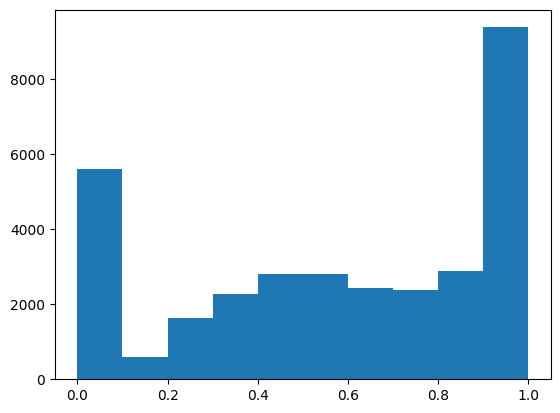

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  0 | Count:  5516 | Corr:  0.0
FeatID:  22182 | Count:  2759 | Corr:  0.0
FeatID:  26084 | Count:  1200 | Corr:  0.37508684
FeatID:  25438 | Count:  411 | Corr:  0.69281346
FeatID:  30962 | Count:  240 | Corr:  0.52269155
FeatID:  28492 | Count:  206 | Corr:  0.0
FeatID:  18190 | Count:  168 | Corr:  0.4132853
FeatID:  32005 | Count:  163 | Corr:  0.61990595
FeatID:  7671 | Count:  153 | Corr:  0.96891075
FeatID:  25857 | Count:  125 | Corr:  0.81508905
FeatID:  13875 | Count:  122 | Corr:  0.6627777
FeatID:  9163 | Count:  122 | Corr:  0.8556058
FeatID:  32355 | Count:  120 | Corr:  0.88651556
FeatID:  32313 | Count:  115 | Corr:  0.71601826
FeatID:  5232 | Count:  111 | Corr:  0.9649693
FeatID:  10610 | Count:  109 | Corr:  0.68610895
FeatID:  16135 | Count:  105 | Corr:  0.0
FeatID:  16916 | Count:  99 | Corr:  0.0
FeatID:  6314 | Count:  94 | Corr:  0.0
FeatID:  24587 | Count:  93 | Corr:  0.0


In [ ]:
# num_featB_to_rmv
sum([item[1] for item in sorted_feat_counts[:17]])

11745

In [ ]:
max_element = len(highest_correlations_indices_AB)
counts = Counter(highest_correlations_indices_AB)

# Initialize bins
bin_0 = 0
bin_1 = 0
bin_2_to_10 = 0
bin_11_to_100 = 0
bin_101_to_1000 = 0
bin_over_1000 = 0

# Calculate bins
for i in range(max_element + 1):
    count = counts.get(i, 0)
    if count == 0:
        bin_0 += 1
    elif count == 1:
        bin_1 += 1
    elif 2 <= count <= 10:
        bin_2_to_10 += 1
    elif 11 <= count <= 100:
        bin_11_to_100 += 1
    elif 101 <= count <= 1000:
        bin_101_to_1000 += 1
    elif count > 1000:
        bin_over_1000 += 1

# Display bin counts
print(f"Count of elements appearing 0 times: {bin_0}")
print(f"Count of elements appearing exactly 1 time: {bin_1}")
print(f"Count of elements appearing between 2 and 10 times: {bin_2_to_10}")
print(f"Count of elements appearing between 11 and 100 times: {bin_11_to_100}")
print(f"Count of elements appearing between 101 and 1000 times: {bin_101_to_1000}")
print(f"Count of elements appearing over 1000 times: {bin_over_1000}")

Count of elements appearing 0 times: 24481
Count of elements appearing exactly 1 time: 4595
Count of elements appearing between 2 and 10 times: 3437
Count of elements appearing between 11 and 100 times: 239
Count of elements appearing between 101 and 1000 times: 14
Count of elements appearing over 1000 times: 3


## rmv 0 corrs

In [ ]:
new_highest_correlations_indices_A = []
new_highest_correlations_indices_B = []
new_highest_correlations_values = []

# for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
for ind_A, ind_B in enumerate(highest_correlations_indices_AB):
    val = highest_correlations_values_AB[ind_A]
    if val > 0:
        new_highest_correlations_indices_A.append(ind_A)
        new_highest_correlations_indices_B.append(ind_B)
        new_highest_correlations_values.append(val)

print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
# dictscores["num_feat_filt"] = len(new_highest_correlations_indices_A)
sum(new_highest_correlations_values) / len(new_highest_correlations_values)

% unique after rmv 0s:  0.30412446792895936
num feats after rmv 0s:  27252


0.6992434832668944

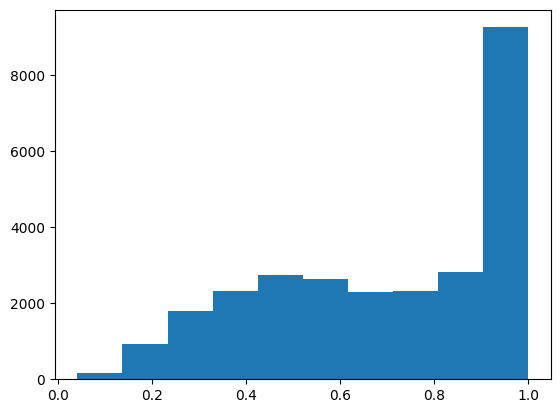

In [ ]:
plt.hist(new_highest_correlations_values)
plt.show()

In [ ]:
len(list(set(new_highest_correlations_indices_A)))

27252

In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

0.039123910243815514

In [ ]:
svcca(weight_matrix_np[new_highest_correlations_indices_B], weight_matrix_2[new_highest_correlations_indices_A], "nd")

0.0006832445235588257

## keep 1-1

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
kept_modB_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 100]

filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in enumerate(highest_correlations_indices_AB):
    if ind_B in kept_modB_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_B not in seen:  # only keep one if it's over count X
        seen.add(ind_B)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
# num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_B))

% unique:  0.39391634980988594
num feats after filt:  21040


In [ ]:
# sum

In [ ]:
svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")

0.3098612745947973

## interpret

In [ ]:
# load weight matrix too

with torch.inference_mode():
#     feature_acts_model_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))
    feature_acts_model_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

In [ ]:
sorted_feat_counts[:5]

[(0, 5516), (22182, 2759), (26084, 1200), (25438, 411), (30962, 240)]

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  0


batchID: 0, Act = 0.00, Seq = "Port-au-Prince,"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti (CNN"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti ("

In [ ]:
feat_A_lst = [ind_A for ind_A, ind_B in enumerate(highest_correlations_indices_AB) if ind_B == 0]
len(feat_A_lst)

5516

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A in feat_A_lst[:5]:
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_A]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    # print('Model B Feature: ', feature_idx_B)
    # ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    # display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Correlation: 0.0
Model A Feature:  0


batchID: 0, Act = 0.00, Seq = "Port-au-Prince,"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti (CNN"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti ("

--------------------------------------------------
Correlation: 0.0
Model A Feature:  1


batchID: 0, Act = 0.00, Seq = "Port-au-Prince,"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti (CNN"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti ("

--------------------------------------------------
Correlation: 0.0
Model A Feature:  2


batchID: 0, Act = 0.00, Seq = "Port-au-Prince,"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti (CNN"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti ("

--------------------------------------------------
Correlation: 0.0
Model A Feature:  6


batchID: 0, Act = 0.00, Seq = "Port-au-Prince,"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti (CNN"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti ("

--------------------------------------------------
Correlation: 0.0
Model A Feature:  15


batchID: 0, Act = 0.00, Seq = "Port-au-Prince,"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti (CNN"
batchID: 0, Act = 0.00, Seq = "Port-au-Prince, Haiti ("

--------------------------------------------------


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_B, count in sorted_feat_counts[1:6]:
    feat_A_lst = [ind_A for ind_A, ind_B in enumerate(highest_correlations_indices_AB) if ind_B == feature_idx_B]
    feature_idx_A = feat_A_lst[0]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 2759
Correlation: 0.0
Model A Feature:  13


batchID: 78, Act = 3.70, Seq = " Kelly’s body – including the knife he supposedly"
batchID: 47, Act = 3.64, Seq = " number of new features, including the ability to schedule"
batchID: 64, Act = 3.56, Seq = " erstwhile officials, including Ane"
batchID: 77, Act = 3.54, Seq = " more legal media sites, including Google's own fled"
batchID: 53, Act = 3.52, Seq = " watch at various markets, including Mai Hera Gate"

Model B Feature:  22182


batchID: 27, Act = 6.36, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 6.36, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 6.35, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 27, Act = 6.35, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 6.34, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

--------------------------------------------------
Count: 1200
Correlation: 0.37508684396743774
Model A Feature:  4


batchID: 11, Act = 0.66, Seq = " the United States 
Senate.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"
batchID: 11, Act = 0.59, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 11, Act = 0.58, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 0.57, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|>"
batchID: 92, Act = 0.57, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"

Model B Feature:  26084


batchID: 10, Act = 10.83, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 10.80, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 10.80, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 10.74, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 10.74, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

--------------------------------------------------
Count: 411
Correlation: 0.6928134560585022
Model A Feature:  10


batchID: 45, Act = 4.07, Seq = " College Football Playoff committee released its first rankings to"
batchID: 86, Act = 3.45, Seq = " school year, are now released in a paper entitled"
batchID: 40, Act = 3.38, Seq = " new branding strategy will be released later this year."
batchID: 88, Act = 3.32, Seq = "arian presidential candidate Bob Barr released a statement today critic"
batchID: 22, Act = 3.24, Seq = " exploration planning document to be released early next year will"

Model B Feature:  25438


batchID: 92, Act = 0.97, Seq = " country should Trump 
win.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"
batchID: 92, Act = 0.97, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 0.96, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 0.95, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 92, Act = 0.94, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

--------------------------------------------------
Count: 240
Correlation: 0.522691547870636
Model A Feature:  148


batchID: 12, Act = 0.94, Seq = "Attention! This news"
batchID: 6, Act = 0.67, Seq = "× Some Seattle businesses closed"
batchID: 55, Act = 0.56, Seq = "Protesters take to"
batchID: 78, Act = 0.41, Seq = "Fingerprint riddle"
batchID: 19, Act = 0.41, Seq = "F ancy cars have"

Model B Feature:  30962


batchID: 10, Act = 0.82, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 0.81, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 0.80, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 0.79, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 0.78, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

--------------------------------------------------
Count: 206
Correlation: 0.0
Model A Feature:  72


batchID: 62, Act = 0.47, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"
batchID: 62, Act = 0.46, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>"
batchID: 62, Act = 0.46, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|>"
batchID: 62, Act = 0.45, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 62, Act = 0.45, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

Model B Feature:  28492


batchID: 10, Act = 0.92, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 10, Act = 0.91, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|>"
batchID: 10, Act = 0.91, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 27, Act = 0.90, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"
batchID: 27, Act = 0.90, Seq = 
"<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex
t|><|endoftext|>"

--------------------------------------------------


## loop- filter counts over 10 and rmv corr of 0

In [ ]:
layer_to_dictscores = run_expm()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.242919921875
num feats after filt:  17033
% unique after rmv 0s:  0.46735556599342415
num feats after rmv 0s:  17032
Layer: 0
mean_actv_corr: 0.49545454355722995
num_feat_filt: 17032
mean_actv_corr_filt: 0.5542658555199785
svcca_paired: 0.07636621946164314
svcca_unpaired: 0.0019508939409156728




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.2586669921875
num feats after filt:  15200
% unique after rmv 0s:  0.5576682676491874
num feats after rmv 0s:  15199
Layer: 1
mean_actv_corr: 0.598344303214617
num_feat_filt: 15199
mean_actv_corr_filt: 0.6647004646740114
svcca_paired: 0.20012052436301778
svcca_unpaired: 0.004715853886006663




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.2529296875
num feats after filt:  15483
% unique after rmv 0s:  0.5353313525384318
num feats after rmv 0s:  15482
Layer: 2
mean_actv_corr: 0.5815363588253604
num_feat_filt: 15482
mean_actv_corr_filt: 0.6357131195701576
svcca_paired: 0.3533016305705766
svcca_unpaired: 0.002240512633190095




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.234588623046875
num feats after filt:  16260
% unique after rmv 0s:  0.4727843040777416
num feats after rmv 0s:  16259
Layer: 3
mean_actv_corr: 0.4770452877586422
num_feat_filt: 16259
mean_actv_corr_filt: 0.479093958639574
svcca_paired: 0.44686075019370625
svcca_unpaired: 0.0035353132090214907




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.19659423828125
num feats after filt:  14585
% unique after rmv 0s:  0.44171695008228196
num feats after rmv 0s:  14584
Layer: 4
mean_actv_corr: 0.41632858831985686
num_feat_filt: 14584
mean_actv_corr_filt: 0.3676127865422646
svcca_paired: 0.44688419340942215
svcca_unpaired: 0.005763826084601558




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.188262939453125
num feats after filt:  13965
% unique after rmv 0s:  0.4417788599255228
num feats after rmv 0s:  13964
Layer: 5
mean_actv_corr: 0.39980965622828535
num_feat_filt: 13964
mean_actv_corr_filt: 0.3272604539390708
svcca_paired: 0.4576952030972132
svcca_unpaired: 0.00011641441910813847




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.1678466796875
num feats after filt:  12356
% unique after rmv 0s:  0.4451639012545528
num feats after rmv 0s:  12355
Layer: 6
mean_actv_corr: 0.3487118506405409
num_feat_filt: 12355
mean_actv_corr_filt: 0.22908429458046892
svcca_paired: 0.43178030257608657
svcca_unpaired: 0.0014012738624688422




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.17156982421875
num feats after filt:  13454
% unique after rmv 0s:  0.4178993533040957
num feats after rmv 0s:  13453
Layer: 7
mean_actv_corr: 0.3843606080371842
num_feat_filt: 13453
mean_actv_corr_filt: 0.30605074280572075
svcca_paired: 0.42615463018271016
svcca_unpaired: 0.0004480503758423141




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.14923095703125
num feats after filt:  10542
% unique after rmv 0s:  0.4639028555165544
num feats after rmv 0s:  10541
Layer: 8
mean_actv_corr: 0.33516071395052904
num_feat_filt: 10541
mean_actv_corr_filt: 0.1897486525863132
svcca_paired: 0.4044554621952791
svcca_unpaired: 0.012775206929962438




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.165008544921875
num feats after filt:  13097
% unique after rmv 0s:  0.4128741600488699
num feats after rmv 0s:  13096
Layer: 9
mean_actv_corr: 0.38868181468376406
num_feat_filt: 13096
mean_actv_corr_filt: 0.3050217139546031
svcca_paired: 0.07794016837182205
svcca_unpaired: 0.004519169583274534




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.4955,
  'num_feat_filt': 17032,
  'mean_actv_corr_filt': 0.5543,
  'svcca_paired': 0.0764,
  'svcca_unpaired': 0.002},
 1: {'mean_actv_corr': 0.5983,
  'num_feat_filt': 15199,
  'mean_actv_corr_filt': 0.6647,
  'svcca_paired': 0.2001,
  'svcca_unpaired': 0.0047},
 2: {'mean_actv_corr': 0.5815,
  'num_feat_filt': 15482,
  'mean_actv_corr_filt': 0.6357,
  'svcca_paired': 0.3533,
  'svcca_unpaired': 0.0022},
 3: {'mean_actv_corr': 0.477,
  'num_feat_filt': 16259,
  'mean_actv_corr_filt': 0.4791,
  'svcca_paired': 0.4469,
  'svcca_unpaired': 0.0035},
 4: {'mean_actv_corr': 0.4163,
  'num_feat_filt': 14584,
  'mean_actv_corr_filt': 0.3676,
  'svcca_paired': 0.4469,
  'svcca_unpaired': 0.0058},
 5: {'mean_actv_corr': 0.3998,
  'num_feat_filt': 13964,
  'mean_actv_corr_filt': 0.3273,
  'svcca_paired': 0.4577,
  'svcca_unpaired': 0.0001},
 6: {'mean_actv_corr': 0.3487,
  'num_feat_filt': 12355,
  'mean_actv_corr_filt': 0.2291,
  'svcca_paired': 0.4318,
  'svcca_unpaire

### plot

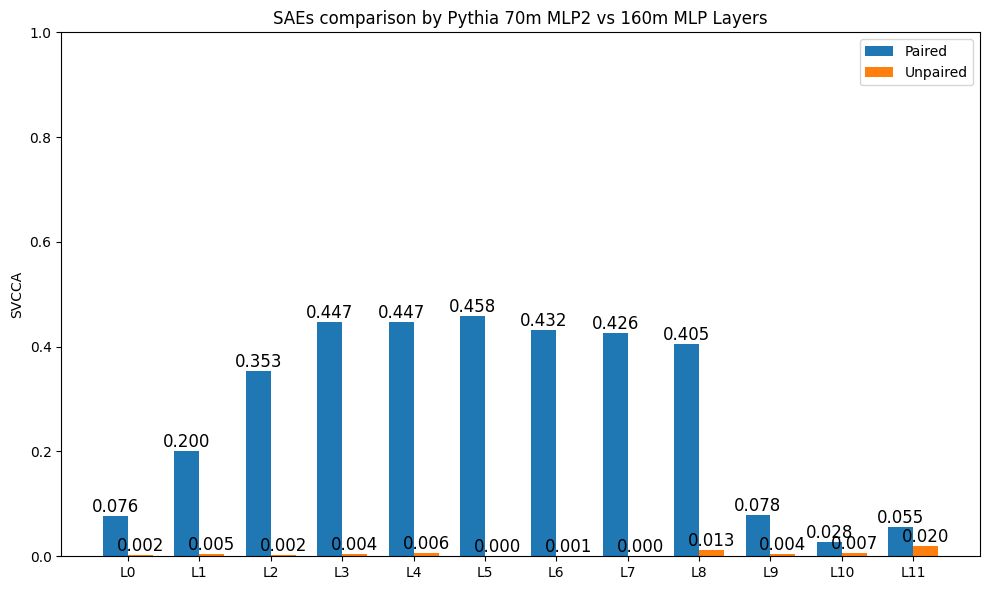

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

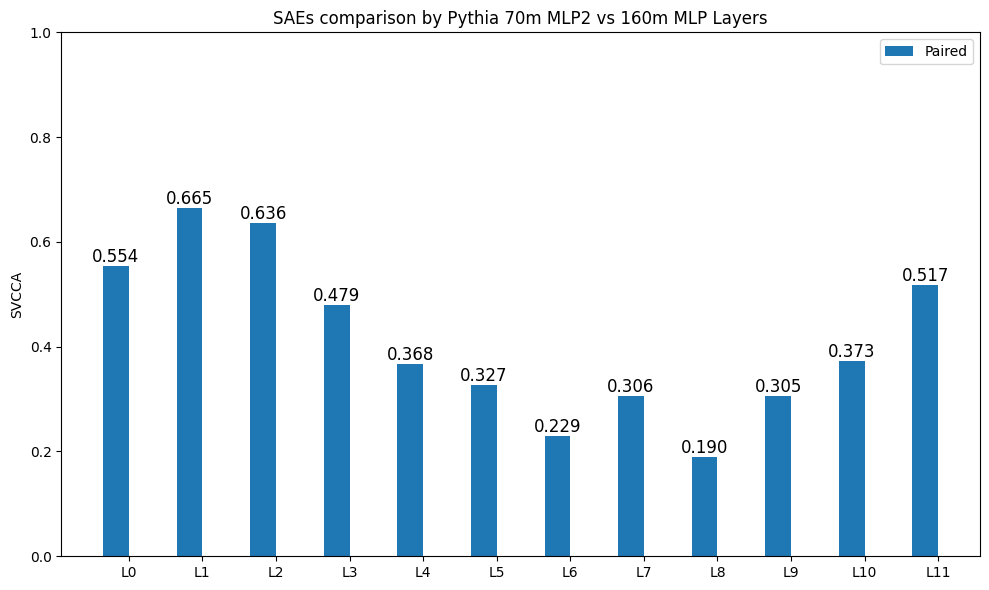

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

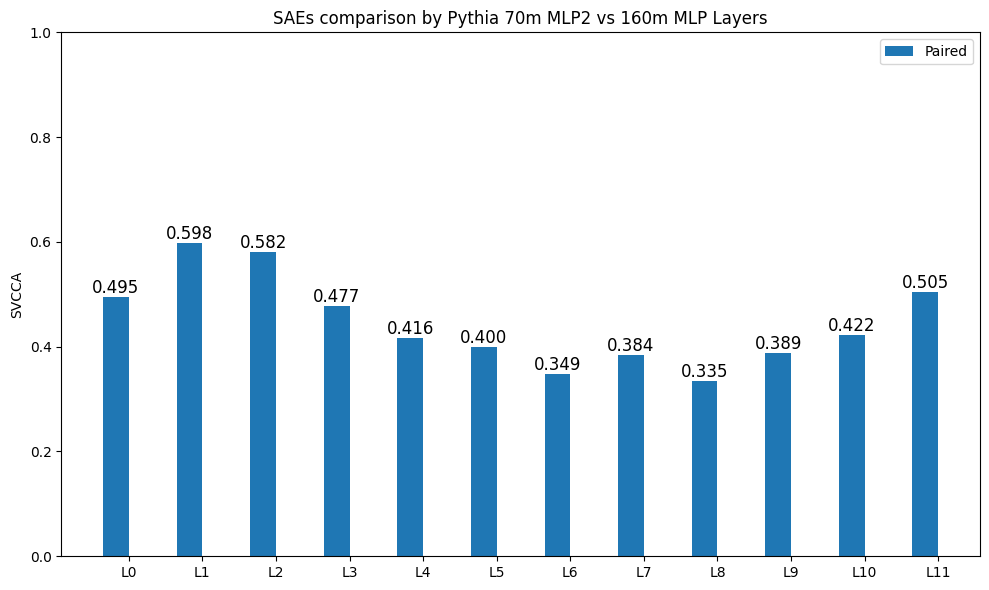

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

# MLP 3

## load SAE model A

In [ ]:
layer_id = 3
weight_matrix_np, reshaped_activations_A = get_weights_and_acts(layer_id, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

layers.3/cfg.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

sae.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

In [ ]:
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

Number of zero columns: 118


## loop- filter counts over 10 and rmv corr of 0

In [ ]:
layer_to_dictscores = run_expm(outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.224090576171875
num feats after filt:  18565
% unique after rmv 0s:  0.39555052790346906
num feats after rmv 0s:  18564
Layer: 0
mean_actv_corr: 0.2922011482128255
num_feat_filt: 18564
mean_actv_corr_filt: 0.31894022264441385
svcca_paired: 0.018634902063944178
svcca_unpaired: 0.010174710518838403




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.28515625
num feats after filt:  21242
% unique after rmv 0s:  0.439903959323949
num feats after rmv 0s:  21241
Layer: 1
mean_actv_corr: 0.37826143611437146
num_feat_filt: 21241
mean_actv_corr_filt: 0.40022357980895246
svcca_paired: 0.1065893407654177
svcca_unpaired: 0.0029042348311897324




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.3228759765625
num feats after filt:  22839
% unique after rmv 0s:  0.4632629827480515
num feats after rmv 0s:  22838
Layer: 2
mean_actv_corr: 0.44425682967198554
num_feat_filt: 22838
mean_actv_corr_filt: 0.4646743348660914
svcca_paired: 0.3292866957916717
svcca_unpaired: 0.012020320959683398




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.26202392578125
num feats after filt:  20712
% unique after rmv 0s:  0.41456230988363674
num feats after rmv 0s:  20711
Layer: 3
mean_actv_corr: 0.30745292731944573
num_feat_filt: 20711
mean_actv_corr_filt: 0.3310115421898197
svcca_paired: 0.3647909972974757
svcca_unpaired: 0.009991977933194925




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.22821044921875
num feats after filt:  18727
% unique after rmv 0s:  0.39933781907508276
num feats after rmv 0s:  18726
Layer: 4
mean_actv_corr: 0.2518519540943771
num_feat_filt: 18726
mean_actv_corr_filt: 0.2658324563685014
svcca_paired: 0.41540046609553566
svcca_unpaired: 0.0038905766802581586




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.220245361328125
num feats after filt:  17844
% unique after rmv 0s:  0.4044723420949392
num feats after rmv 0s:  17843
Layer: 5
mean_actv_corr: 0.24415793589810164
num_feat_filt: 17843
mean_actv_corr_filt: 0.24954728021794342
svcca_paired: 0.42963039286876575
svcca_unpaired: 0.002166876444265445




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.227630615234375
num feats after filt:  17394
% unique after rmv 0s:  0.4288506870580118
num feats after rmv 0s:  17393
Layer: 6
mean_actv_corr: 0.20912708596040375
num_feat_filt: 17393
mean_actv_corr_filt: 0.20250675087732656
svcca_paired: 0.41965271106753105
svcca_unpaired: 0.018901964483741134




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.222503662109375
num feats after filt:  17614
% unique after rmv 0s:  0.41395560097655143
num feats after rmv 0s:  17613
Layer: 7
mean_actv_corr: 0.22647177313285738
num_feat_filt: 17613
mean_actv_corr_filt: 0.22545479469613397
svcca_paired: 0.40989958339058574
svcca_unpaired: 0.00429461351428072




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.225006103515625
num feats after filt:  16831
% unique after rmv 0s:  0.43808674985145574
num feats after rmv 0s:  16830
Layer: 8
mean_actv_corr: 0.17541336224445558
num_feat_filt: 16830
mean_actv_corr_filt: 0.15742213537864524
svcca_paired: 0.4032778289643094
svcca_unpaired: 0.007145213913378644




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.20245361328125
num feats after filt:  16155
% unique after rmv 0s:  0.4106722793116256
num feats after rmv 0s:  16154
Layer: 9
mean_actv_corr: 0.20319772418042703
num_feat_filt: 16154
mean_actv_corr_filt: 0.1977270340142935
svcca_paired: 0.28875483108201677
svcca_unpaired: 0.006865528932891101




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.1585693359375
num feats after filt:  12754
% unique after rmv 0s:  0.40743354504822393
num feats after rmv 0s:  12753
Layer: 10
mean_actv_corr: 0.18430480021987705
num_feat_filt: 12753
mean_actv_corr_filt: 0.1794906681540664
svcca_paired: 0.0424965297924392
svcca_unpaired: 0.007494912820769934




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

sae.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

% unique:  0.212249755859375
num feats after filt:  18822
% unique after rmv 0s:  0.3695340311354338
num feats after rmv 0s:  18821
Layer: 11
mean_actv_corr: 0.2997874766483619
num_feat_filt: 18821
mean_actv_corr_filt: 0.31022051583486066
svcca_paired: 0.031572793054893314
svcca_unpaired: 0.012707673957381921




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.2922011482128255,
  'num_feat_filt': 18564,
  'mean_actv_corr_filt': 0.31894022264441385,
  'svcca_paired': 0.018634902063944178,
  'svcca_unpaired': 0.010174710518838403},
 1: {'mean_actv_corr': 0.37826143611437146,
  'num_feat_filt': 21241,
  'mean_actv_corr_filt': 0.40022357980895246,
  'svcca_paired': 0.1065893407654177,
  'svcca_unpaired': 0.0029042348311897324},
 2: {'mean_actv_corr': 0.44425682967198554,
  'num_feat_filt': 22838,
  'mean_actv_corr_filt': 0.4646743348660914,
  'svcca_paired': 0.3292866957916717,
  'svcca_unpaired': 0.012020320959683398},
 3: {'mean_actv_corr': 0.30745292731944573,
  'num_feat_filt': 20711,
  'mean_actv_corr_filt': 0.3310115421898197,
  'svcca_paired': 0.3647909972974757,
  'svcca_unpaired': 0.009991977933194925},
 4: {'mean_actv_corr': 0.2518519540943771,
  'num_feat_filt': 18726,
  'mean_actv_corr_filt': 0.2658324563685014,
  'svcca_paired': 0.41540046609553566,
  'svcca_unpaired': 0.0038905766802581586},
 5: {'mean_actv

### plot

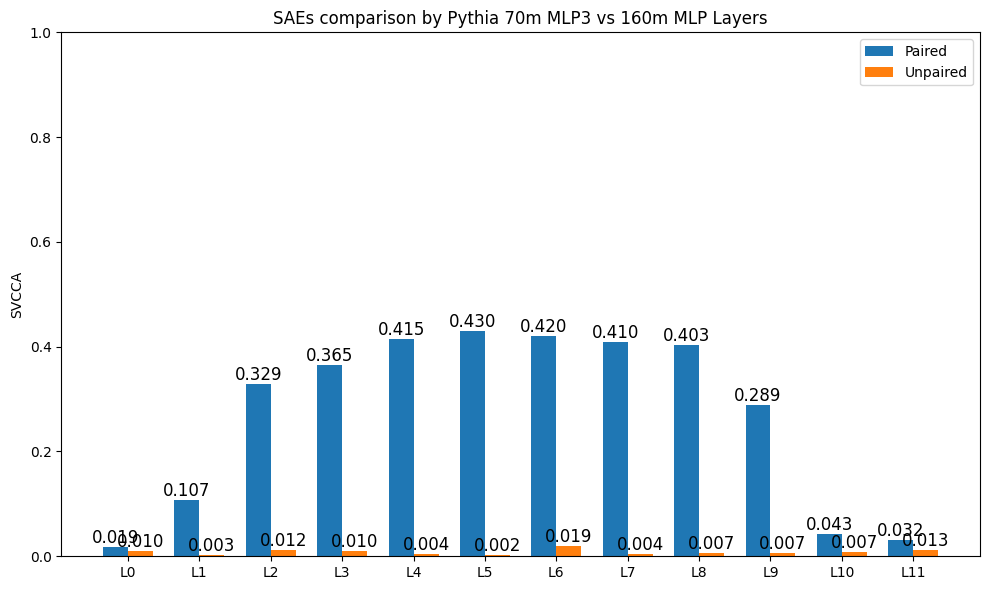

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

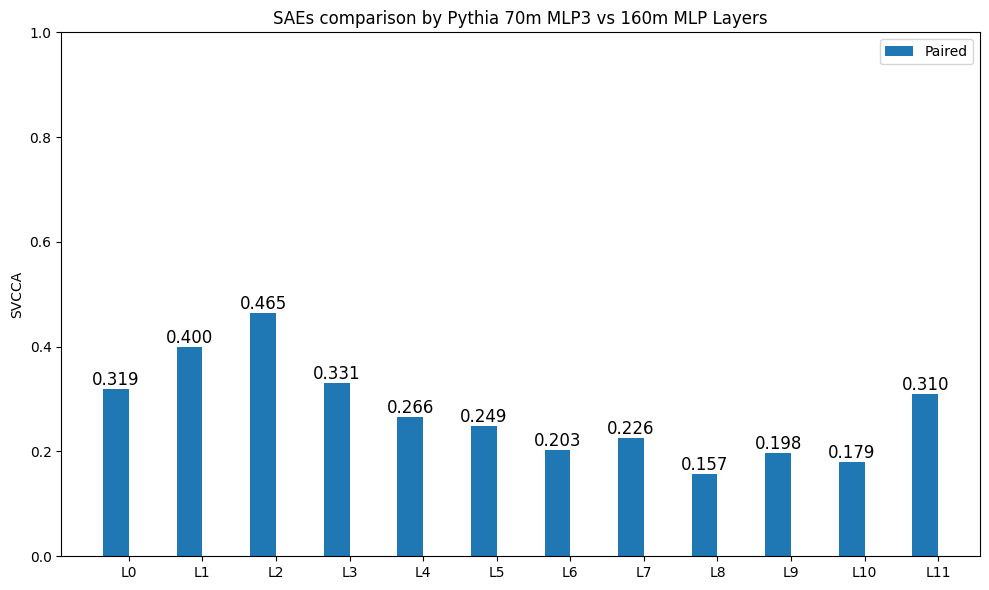

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

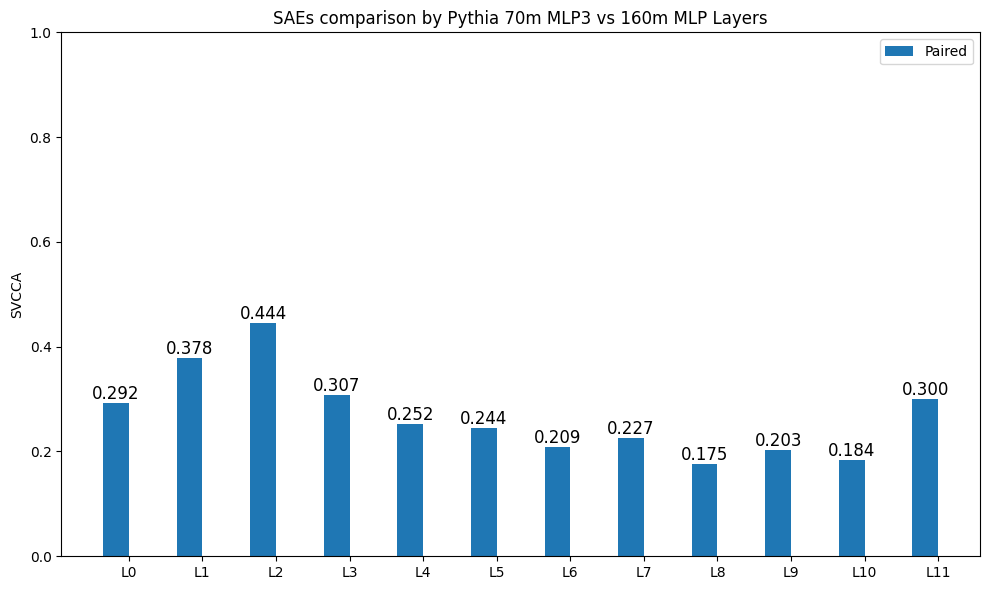

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)

# MLP 5

## load SAE model A

In [ ]:
layer_id = 5
weight_matrix_np, reshaped_activations_A = get_weights_and_acts(layer_id, outputs)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

Number of zero columns: 139


## loop- filter counts over 10 and rmv corr of 0

In [ ]:
layer_to_dictscores = run_expm(outputs_2)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.210357666015625
num feats after filt:  14295
% unique after rmv 0s:  0.4822303064222751
num feats after rmv 0s:  14294
Layer: 0
mean_actv_corr: 0.5703042473677442
num_feat_filt: 14294
mean_actv_corr_filt: 0.505084328089919
svcca_paired: 0.045120828286423754
svcca_unpaired: 0.006855339158070028




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.157928466796875
num feats after filt:  10377
% unique after rmv 0s:  0.49874710871241323
num feats after rmv 0s:  10376
Layer: 1
mean_actv_corr: 0.5893256395802382
num_feat_filt: 10376
mean_actv_corr_filt: 0.36026472176310986
svcca_paired: 0.020988509579920364
svcca_unpaired: 0.00803114176036644




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.143951416015625
num feats after filt:  8903
% unique after rmv 0s:  0.5298809256346888
num feats after rmv 0s:  8902
Layer: 2
mean_actv_corr: 0.6054100648589156
num_feat_filt: 8902
mean_actv_corr_filt: 0.36607292390584784
svcca_paired: 0.07881785386748234
svcca_unpaired: 2.1798323482928656e-05




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.159149169921875
num feats after filt:  9475
% unique after rmv 0s:  0.5504538737597635
num feats after rmv 0s:  9474
Layer: 3
mean_actv_corr: 0.6220949764456236
num_feat_filt: 9474
mean_actv_corr_filt: 0.4125123704526654
svcca_paired: 0.09869686452953966
svcca_unpaired: 0.0071709996342436905




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.160369873046875
num feats after filt:  9413
% unique after rmv 0s:  0.5583297917552061
num feats after rmv 0s:  9412
Layer: 4
mean_actv_corr: 0.6171225989394316
num_feat_filt: 9412
mean_actv_corr_filt: 0.41598617942046723
svcca_paired: 0.11396798730466838
svcca_unpaired: 0.001482458849472394




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.167236328125
num feats after filt:  10395
% unique after rmv 0s:  0.5272272464883586
num feats after rmv 0s:  10394
Layer: 5
mean_actv_corr: 0.603852405106295
num_feat_filt: 10394
mean_actv_corr_filt: 0.4137403177793109
svcca_paired: 0.14740607793729968
svcca_unpaired: 0.006078666591241703




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.1728515625
num feats after filt:  11150
% unique after rmv 0s:  0.5080276257960356
num feats after rmv 0s:  11149
Layer: 6
mean_actv_corr: 0.5813244103628676
num_feat_filt: 11149
mean_actv_corr_filt: 0.384895506361796
svcca_paired: 0.11969852491164057
svcca_unpaired: 0.010592797320104489




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.176971435546875
num feats after filt:  11501
% unique after rmv 0s:  0.5042608695652174
num feats after rmv 0s:  11500
Layer: 7
mean_actv_corr: 0.5848721154486611
num_feat_filt: 11500
mean_actv_corr_filt: 0.39483453198554724
svcca_paired: 0.0909791020639665
svcca_unpaired: 0.011085129981048483




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.167633056640625
num feats after filt:  10656
% unique after rmv 0s:  0.5155326137963397
num feats after rmv 0s:  10655
Layer: 8
mean_actv_corr: 0.5615488317096151
num_feat_filt: 10655
mean_actv_corr_filt: 0.3249351146448699
svcca_paired: 0.22210866682430785
svcca_unpaired: 0.0047449361073234764




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.161468505859375
num feats after filt:  10426
% unique after rmv 0s:  0.5075299760191847
num feats after rmv 0s:  10425
Layer: 9
mean_actv_corr: 0.5533382058767984
num_feat_filt: 10425
mean_actv_corr_filt: 0.35906603379965685
svcca_paired: 0.19257362113553284
svcca_unpaired: 0.0013846420963933717




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.154754638671875
num feats after filt:  10631
% unique after rmv 0s:  0.47704609595484476
num feats after rmv 0s:  10630
Layer: 10
mean_actv_corr: 0.5419621985535059
num_feat_filt: 10630
mean_actv_corr_filt: 0.42903544020121487
svcca_paired: 0.09786258333904493
svcca_unpaired: 0.00015513159423391967




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.18511962890625
num feats after filt:  12423
% unique after rmv 0s:  0.4883271614876831
num feats after rmv 0s:  12422
Layer: 11
mean_actv_corr: 0.587300496398143
num_feat_filt: 12422
mean_actv_corr_filt: 0.4304940897447776
svcca_paired: 0.17970541294662548
svcca_unpaired: 0.002211625747394753




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.5703042473677442,
  'num_feat_filt': 14294,
  'mean_actv_corr_filt': 0.505084328089919,
  'svcca_paired': 0.045120828286423754,
  'svcca_unpaired': 0.006855339158070028},
 1: {'mean_actv_corr': 0.5893256395802382,
  'num_feat_filt': 10376,
  'mean_actv_corr_filt': 0.36026472176310986,
  'svcca_paired': 0.020988509579920364,
  'svcca_unpaired': 0.00803114176036644},
 2: {'mean_actv_corr': 0.6054100648589156,
  'num_feat_filt': 8902,
  'mean_actv_corr_filt': 0.36607292390584784,
  'svcca_paired': 0.07881785386748234,
  'svcca_unpaired': 2.1798323482928656e-05},
 3: {'mean_actv_corr': 0.6220949764456236,
  'num_feat_filt': 9474,
  'mean_actv_corr_filt': 0.4125123704526654,
  'svcca_paired': 0.09869686452953966,
  'svcca_unpaired': 0.0071709996342436905},
 4: {'mean_actv_corr': 0.6171225989394316,
  'num_feat_filt': 9412,
  'mean_actv_corr_filt': 0.41598617942046723,
  'svcca_paired': 0.11396798730466838,
  'svcca_unpaired': 0.001482458849472394},
 5: {'mean_actv_c

### plot

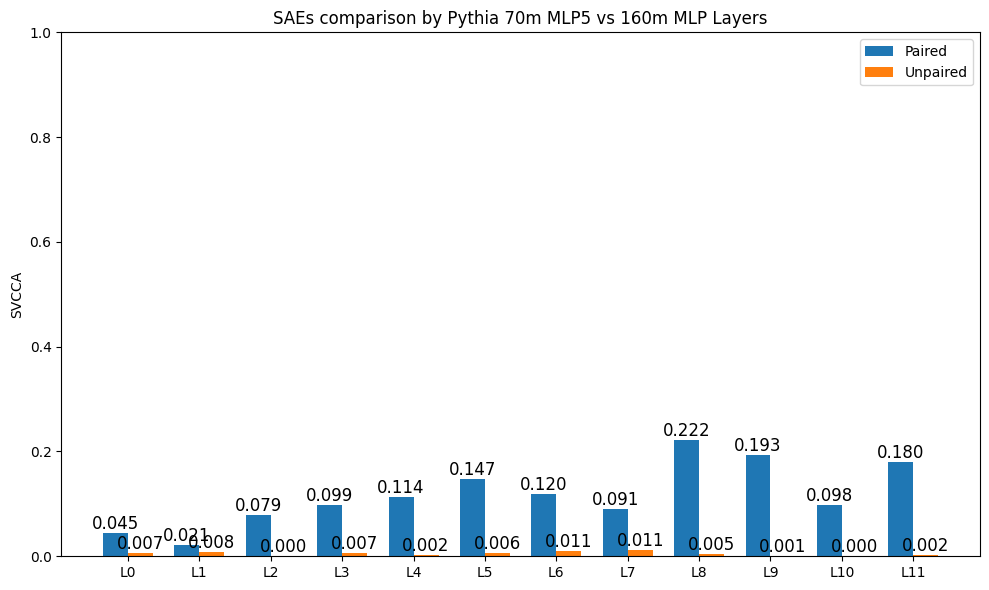

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

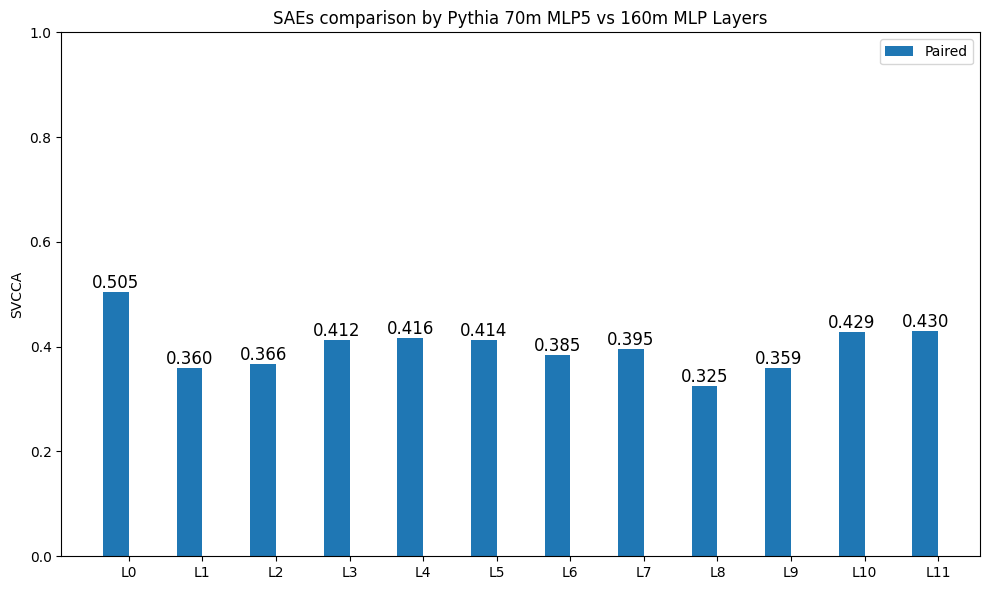

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

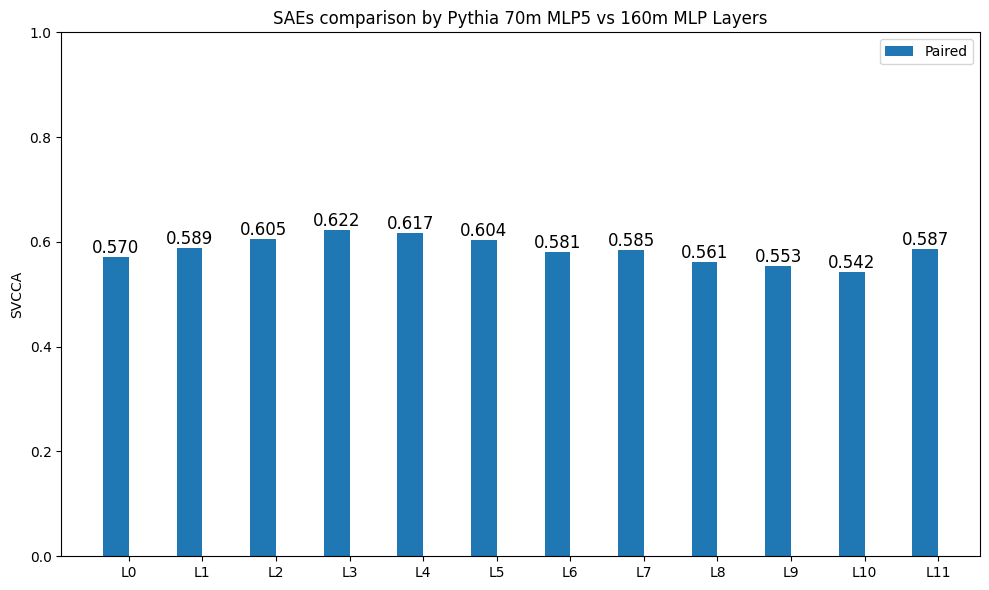

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)